In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/XRAY"
%cd /content/drive/MyDrive/XRAY
os.getcwd()

/content/drive/MyDrive/XRAY


'/content/drive/MyDrive/XRAY'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip *.zip
!rm -rf *.zip

In [ ]:
!pip install visualkeras
!pip install vit_keras -q
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import necessary models


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
from skimage.transform import resize
from skimage.io import imread
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import visualkeras

import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.random import set_seed
from vit_keras import  vit, utils
set_seed(42)
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## Load Datasets for Traditional ML Models

In [ ]:
BASE_PATH = "/content/drive/MyDrive/XRAY/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH = os.path.join(BASE_PATH, "val")
TEST_PATH = os.path.join(BASE_PATH, "test")
def load_data(dir):
    Categories=['NORMAL','PNEUMONIA']
    X_arr=[]#input array
    Y_arr=[] #output array
    for i in Categories:
        print(f'loading... category : {i}')
        path=os.path.join(dir,i)
        for img in os.listdir(path):
            img_array=imread(os.path.join(path,img))
            img_resized=resize(img_array,(100,100,3))
            X_arr.append(img_resized.flatten()/255)
            Y_arr.append(Categories.index(i))
        print(f'loaded category:{i} successfully')
    print("Completed!")
    return X_arr,Y_arr

X_train, y_train = load_data(TRAIN_PATH)
X_val, y_val = load_data(VAL_PATH)
X_test, y_test = load_data(TEST_PATH)



loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!
loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!
loading... category : NORMAL
loaded category:NORMAL successfully
loading... category : PNEUMONIA
loaded category:PNEUMONIA successfully
Completed!


## Model Building : Traditional

### SVC Model

In [ ]:
from sklearn.svm import SVC
model_svm=SVC(C=0.1,kernel='rbf' )
model_svm.fit(X_train,y_train)
y_predict = model_svm.predict(X_test)
display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)))

0           1  accuracy   macro avg  weighted avg
precision    0.948454    0.730550  0.764423    0.839502      0.812264
recall       0.393162    0.987179  0.764423    0.690171      0.764423
f1-score     0.555891    0.839695  0.764423    0.697793      0.733268
support    234.000000  390.000000  0.764423  624.000000    624.000000

### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
model_reg = LogisticRegression(solver='liblinear',C=1)
model_reg.fit(X_train,y_train)
y_predict = model_reg.predict(X_test)
display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)))

0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.631068  0.634615    0.815534      0.769417
recall       0.025641    1.000000  0.634615    0.512821      0.634615
f1-score     0.050000    0.773810  0.634615    0.411905      0.502381
support    234.000000  390.000000  0.634615  624.000000    624.000000

### K-nearest Neighborhood

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_predict = model_knn.predict(X_test)
display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)))


0           1  accuracy   macro avg  weighted avg
precision    0.963855    0.715342  0.748397    0.839599      0.808535
recall       0.341880    0.992308  0.748397    0.667094      0.748397
f1-score     0.504732    0.831364  0.748397    0.668048      0.708877
support    234.000000  390.000000  0.748397  624.000000    624.000000

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(max_depth=10,n_estimators=150)
model_rfc.fit(X_train, y_train)
y_predict = model_rfc.predict(X_test)
display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)))

0           1  accuracy   macro avg  weighted avg
precision    0.976471    0.719852  0.754808    0.848161      0.816084
recall       0.354701    0.994872  0.754808    0.674786      0.754808
f1-score     0.520376    0.835307  0.754808    0.677841      0.717208
support    234.000000  390.000000  0.754808  624.000000    624.000000

## Load datasets for Neural Models

Number of training files: 5216
Number of validation files: 16
Number of test files: 624
Total Pneumonia Images: 4273
Total Normal Images: 1583
The dimensions of the image are 1858 pixels width and 2090 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 128.9075 and the standard deviation is 62.3010


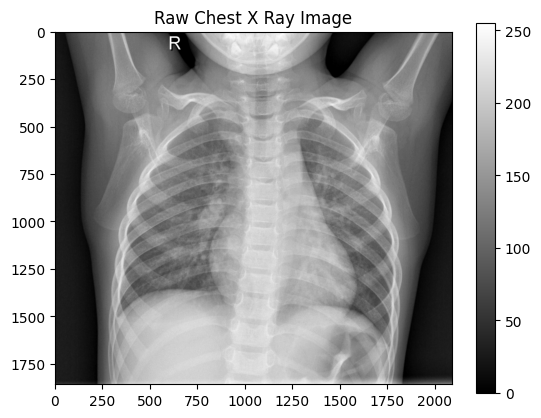

In [ ]:
BASE_PATH = "/content/drive/MyDrive/XRAY/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VAL_PATH = os.path.join(BASE_PATH, "val")
TEST_PATH = os.path.join(BASE_PATH, "test")

TRAIN_FILES = glob.glob(TRAIN_PATH+"/**/*.jpeg")
VAL_FILES = glob.glob(VAL_PATH+"/**/*.jpeg")
TEST_FILES = glob.glob(TEST_PATH+"/**/*.jpeg")

print("Number of training files: {}".format(len(TRAIN_FILES)))
print("Number of validation files: {}".format(len(VAL_FILES)))
print("Number of test files: {}".format(len(TEST_FILES)))

splits = ["train", "val", "test"]
all_pneumonia = []
all_normal = []

for split in splits:
    path = os.path.join(BASE_PATH, split)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print("Total Pneumonia Images: {}".format(len(all_pneumonia)))
print("Total Normal Images: {}".format(len(all_normal)))

normal_img = os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))[0]
sample_img = plt.imread(os.path.join(TRAIN_PATH,"NORMAL", normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")


### Weighting by Class

In [ ]:
# Class weights

weight_for_0 = len(all_pneumonia) / (len(all_pneumonia) + len(all_normal))
weight_for_1 = len(all_normal) / (len(all_normal) + len(all_pneumonia))

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.73
Weight for class 1: 0.27


### Create Data Generators

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42
EPOCH = 20
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(TRAIN_PATH,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            seed = SEED,
                                            target_size=(IMG_SIZE, IMG_SIZE))

validation = image_generator.flow_from_directory(VAL_PATH,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                seed = SEED,
                                                target_size=(IMG_SIZE, IMG_SIZE))

test = image_generator.flow_from_directory(TEST_PATH,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            seed = SEED,
                                            target_size=(IMG_SIZE, IMG_SIZE))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building : Neural

### Shallow Models : CNN

In [ ]:
keras.backend.clear_session()


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)

#### Visualize CNN Model

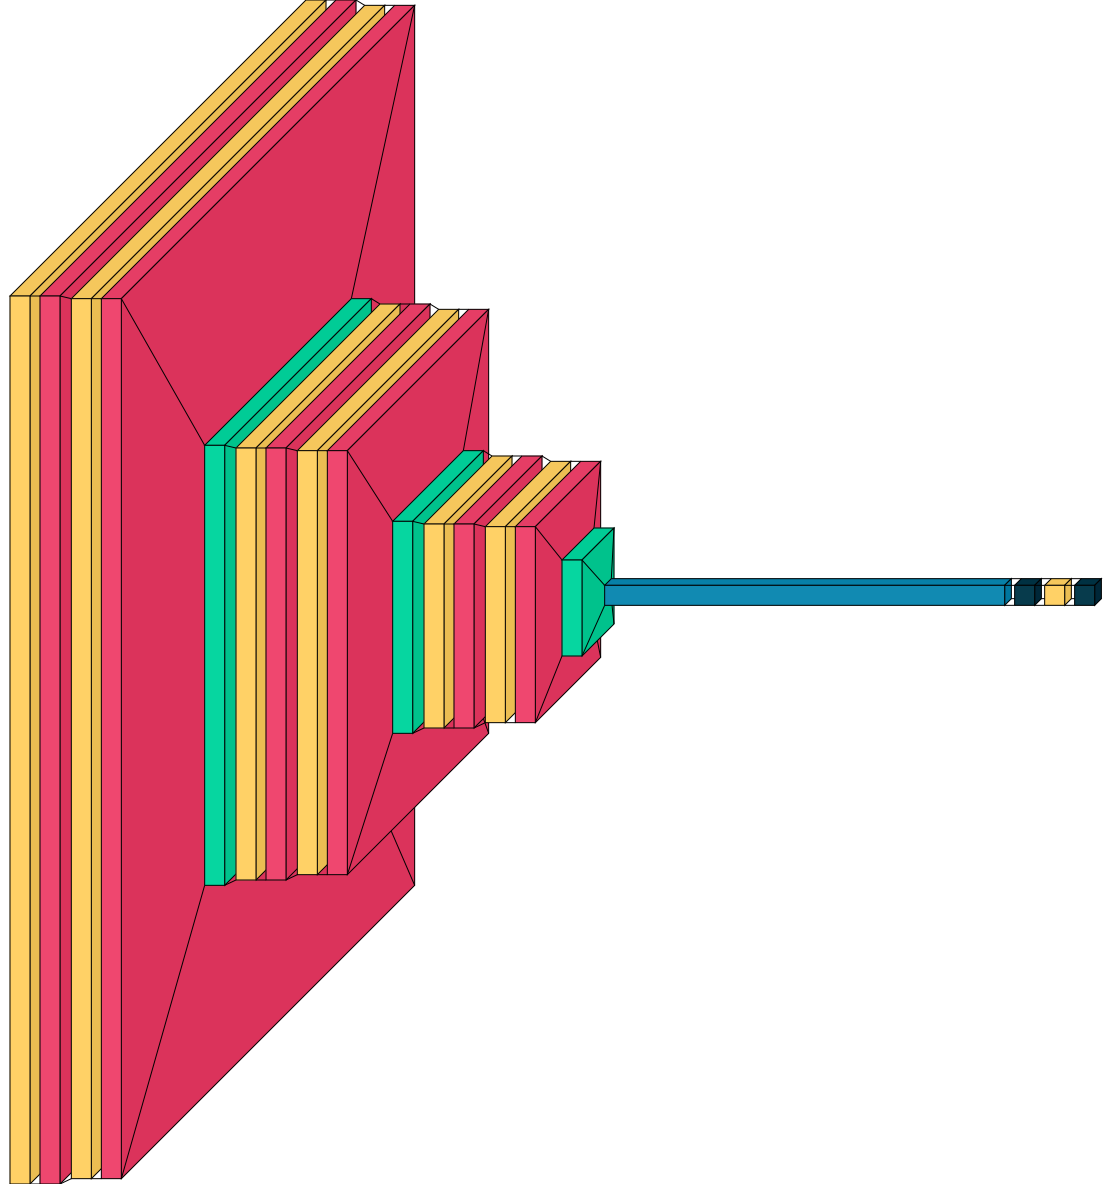

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                        

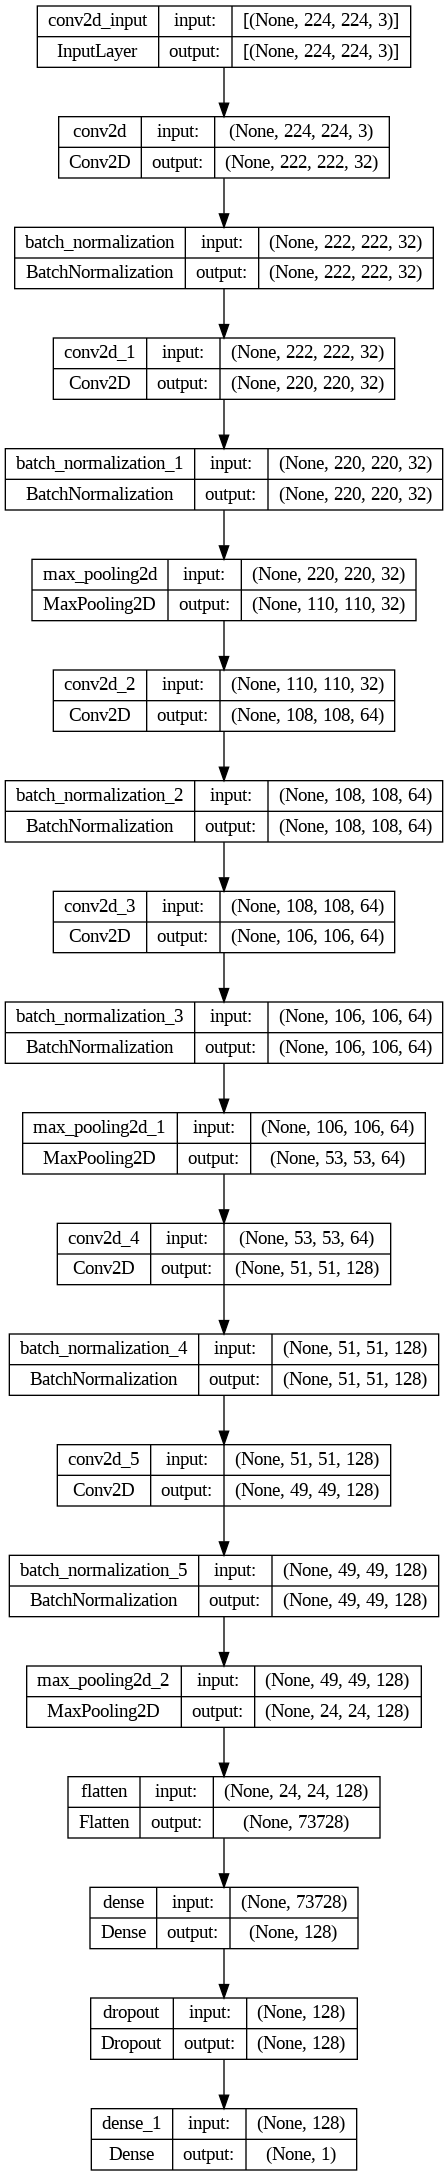

In [ ]:
visualkeras.layered_view(model, to_file='/content/drive/MyDrive/XRAY/assets/layered_model_cnn.png.png').show() # display using your system viewer
model.summary()

tf.keras.utils.plot_model(
    model,
    to_file='/content/drive/MyDrive/XRAY/assets/model_cnn.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)


#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_log = model.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train) // BATCH,
    validation_steps=len(validation),
)

Epoch 1/20
20/20 [==============================] - 19s 779ms/step - loss: 10.4478 - accuracy: 0.1000 - precision: 0.8073 - recall: 0.7097 - val_loss: 1.4644 - val_accuracy: 0.0000e+00 - val_precision: 0.5000 - val_recall: 0.8750 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 17s 811ms/step - loss: 0.4814 - accuracy: 0.0000e+00 - precision: 0.9256 - recall: 0.8960 - val_loss: 0.8667 - val_accuracy: 0.0000e+00 - val_precision: 0.5000 - val_recall: 0.8750 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 16s 820ms/step - loss: 0.6243 - accuracy: 0.0000e+00 - precision: 0.8509 - recall: 0.8818 - val_loss: 0.9563 - val_accuracy: 0.0000e+00 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.0000e+00 - precision: 0.8496 - recall: 0.9339
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 14s 672ms/ste

#### Plot Training Progress

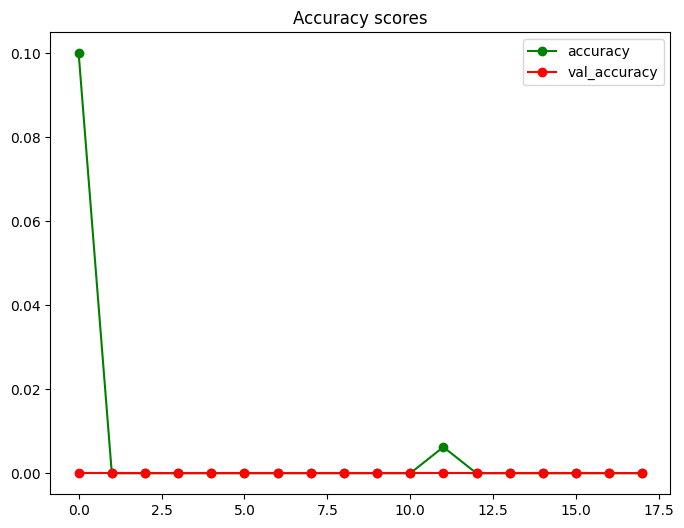

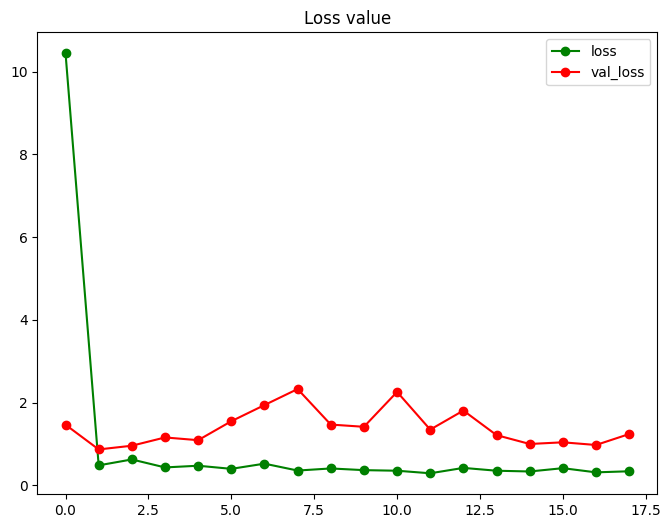

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_log.history['accuracy'],'go-')
plt.plot(trainer_log.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/cnn_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_log.history['loss'],'go-')
plt.plot(trainer_log.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/cnn_loss.png")

plt.show()

#### Model Evaluation

In [ ]:
pred = model.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True)))
# Save the model
model.save("/content/drive/MyDrive/XRAY/assets/best_model_CNN.hdf5")

624/624 [==============================] - 164s 263ms/step
[[ 47 187]
 [  3 387]]


0           1  accuracy   macro avg  weighted avg
precision    0.940000    0.674216  0.695513    0.807108      0.773885
recall       0.200855    0.992308  0.695513    0.596581      0.695513
f1-score     0.330986    0.802905  0.695513    0.566945      0.625935
support    234.000000  390.000000  0.695513  624.000000    624.000000

### Transfer Learning : DenseNet

In [ ]:
from keras.applications.densenet import DenseNet121


keras.backend.clear_session()

densenet_base_model = DenseNet121(include_top=False, weights='imagenet')
x = densenet_base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x)

model_dense = Model(inputs=densenet_base_model.input, outputs=predictions)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_dense.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)

# model_dense.summary()

29084464/29084464 [==============================] - 2s 0us/step


#### Visualize DenseNet

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



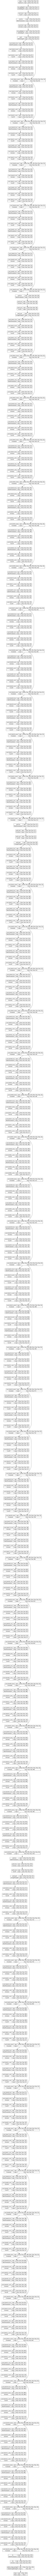

In [ ]:
# print(model_dense.summary())
tf.keras.utils.plot_model(
    model_dense,
    to_file='/content/drive/MyDrive/XRAY/assets/model_dnet.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_dense = model_dense.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train)//BATCH,
    validation_steps=len(validation),
)

#### Plot Training Progress

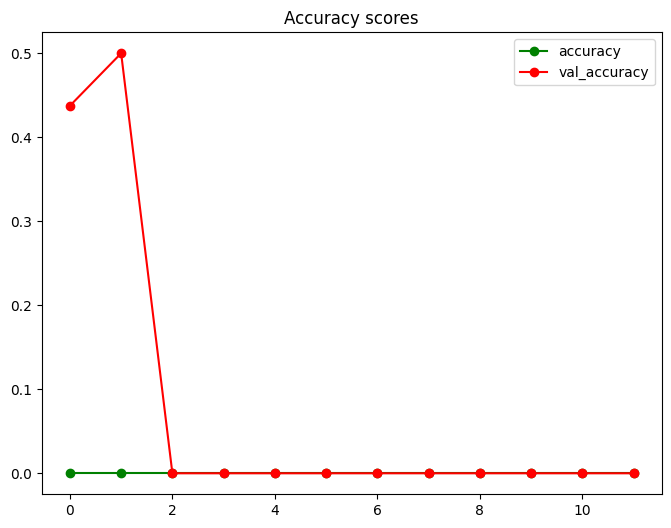

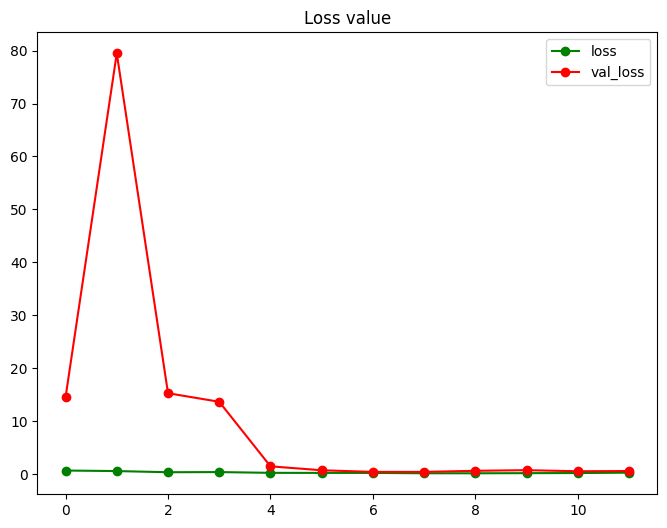

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_dense.history['accuracy'],'go-')
plt.plot(trainer_dense.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/dnet_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_dense.history['loss'],'go-')
plt.plot(trainer_dense.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/dnet_loss.png")

plt.show()

#### Model Evaluation


In [ ]:
pred = model_dense.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True)))
# Save the model
# model_dense.save("/content/drive/MyDrive/XRAY/assets/best_model_DenseNet.hdf5")

(array([  0,   0,   0, ..., 623, 623, 623]),
 array([  0,   1,   2, ..., 621, 622, 623]))

In [ ]:
new_pred = [1 if pred[i] > 0.5 else 0 for i in range(len(pred))]
import numpy as np
fnames = test.filenames ## fnames is all the filenames/samples used in testing
errors = np.where(new_pred != test.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
len(errors)

80

In [ ]:
error_dict = {0: 0, 1: 0}
for idx in errors:
    if new_pred[idx] == 0 : error_dict[0] +=1
    else  : error_dict[1] +=1
error_dict

{0: 32, 1: 48}

[345, 120, 451, 379]


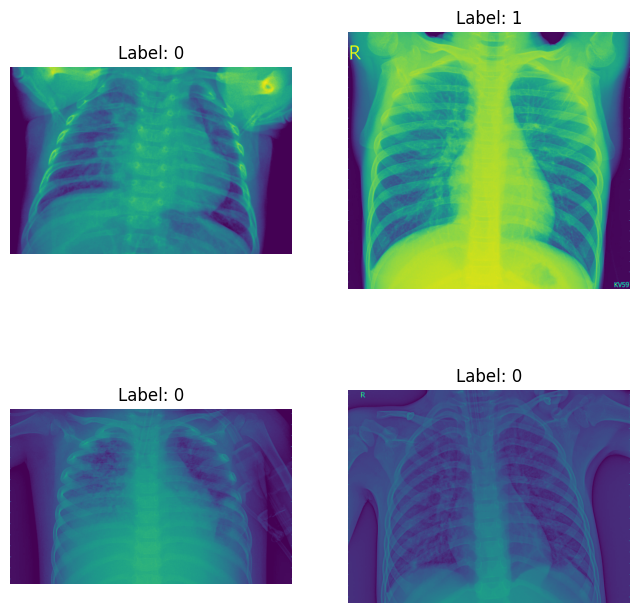

In [ ]:
# import random
# image_paths = random.choices(list(errors), k=4)
print(image_paths)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the figure size
plt.figure(figsize=(8, 8))

# Plot the first image
plt.subplot(2, 2, 1)
img = mpimg.imread(TEST_PATH+"/"+fnames[image_paths[0]])
plt.title("Label: "+ str(new_pred[345]))
plt.imshow(img)
plt.axis('off')

# Plot the second image
plt.subplot(2, 2, 2)
img = mpimg.imread(TEST_PATH+"/"+fnames[image_paths[1]])
plt.title("Label: "+ str(new_pred[120]))

plt.imshow(img)
plt.axis('off')

# Plot the third image
plt.subplot(2, 2, 3)
img = mpimg.imread(TEST_PATH+"/"+fnames[image_paths[2]])
plt.title("Label: "+ str(new_pred[451]))

plt.imshow(img)
plt.axis('off')

# Plot the fourth image
plt.subplot(2, 2, 4)
img = mpimg.imread(TEST_PATH+"/"+fnames[image_paths[3]])
plt.title("Label: "+ str(new_pred[379]))
plt.imshow(img)
plt.axis('off')

# Show the plot
plt.show()


### Transfer Learning : VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
vgg16_base_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3),include_top=False,weights='imagenet')

model_vgg = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_vgg.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)

58889256/58889256 [==============================] - 0s 0us/step


#### Visualize VGG Model

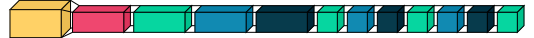

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                        

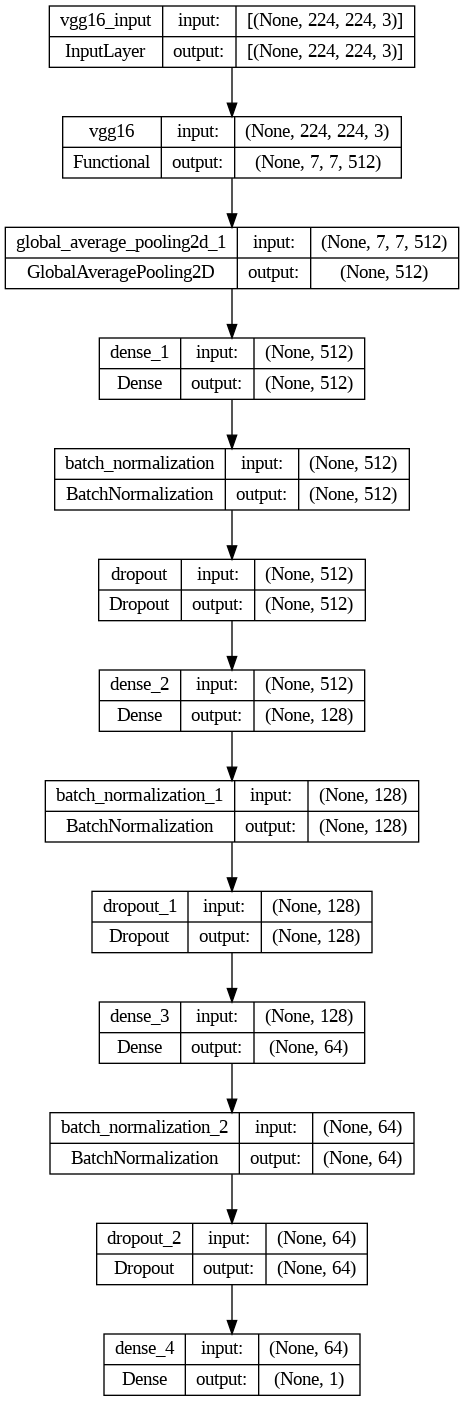

In [ ]:
visualkeras.layered_view(model_vgg, to_file="/content/drive/MyDrive/XRAY/assets/layered_model_vgg.png").show() # display using your system viewer
print(model.summary())
tf.keras.utils.plot_model(
    model_vgg,
    to_file='/content/drive/MyDrive/XRAY/assets/model_vgg.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_vgg = model_vgg.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train) // BATCH,
    validation_steps=len(validation),
    validation_freq=1
)

Epoch 1/20
20/20 [==============================] - 19s 424ms/step - loss: 0.9126 - accuracy: 0.0000e+00 - precision: 0.8400 - recall: 0.5040 - val_loss: 7937.9517 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 9s 434ms/step - loss: 0.8087 - accuracy: 0.0000e+00 - precision: 0.9186 - recall: 0.6423 - val_loss: 13065.7021 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 10s 493ms/step - loss: 0.6856 - accuracy: 0.0000e+00 - precision: 0.8824 - recall: 0.6579 - val_loss: 3.8806 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 10s 479ms/step - loss: 0.6619 - accuracy: 0.0000e+00 - precision: 0.9524 - recall: 0.6780 - val_loss: 0.6038 - val_accuracy: 0.0000e+00 - val_precision: 0.5455 - val_recall: 0.7500 - lr: 0.0010
Ep

#### Plot Training Progress

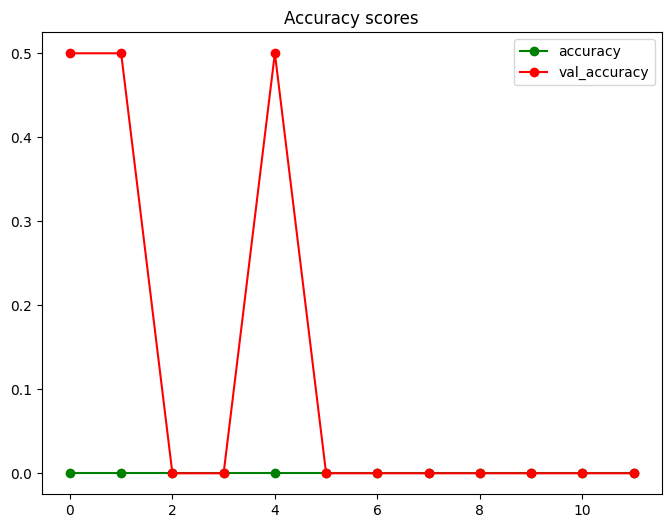

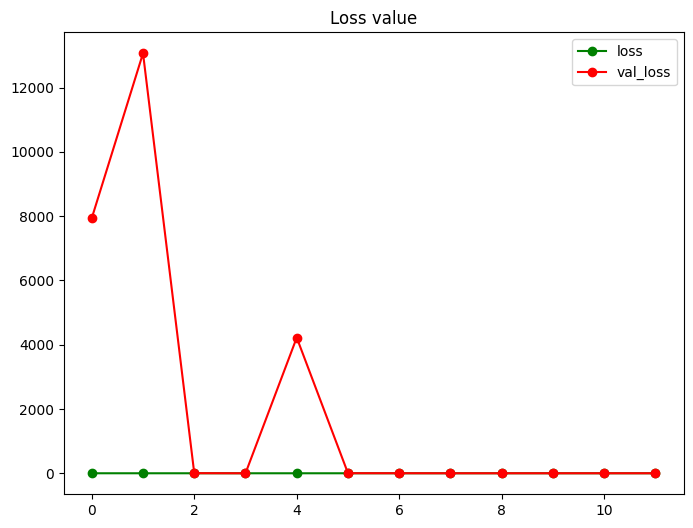

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_vgg.history['accuracy'],'go-')
plt.plot(trainer_vgg.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/vgg_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_vgg.history['loss'],'go-')
plt.plot(trainer_vgg.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/vgg_loss.png")

plt.show()

#### Model Evaluation

In [ ]:
pred = model_vgg.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True)))
# Save the model
model_vgg.save("/content/drive/MyDrive/XRAY/assets/best_model_VGG.hdf5")

624/624 [==============================] - 24s 39ms/step
[[ 81 153]
 [ 30 360]]


0           1  accuracy   macro avg  weighted avg
precision    0.729730    0.701754  0.706731    0.715742      0.712245
recall       0.346154    0.923077  0.706731    0.634615      0.706731
f1-score     0.469565    0.797342  0.706731    0.633454      0.674426
support    234.000000  390.000000  0.706731  624.000000    624.000000

### Transfer Learning : InceptionNet

In [ ]:
from keras.applications import InceptionV3
keras.backend.clear_session()

inception_base_model = InceptionV3(
weights="imagenet",
input_shape=(IMG_SIZE,IMG_SIZE,3),
include_top=False)
model_icp =  tf.keras.Sequential([
        inception_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])


opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_icp.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)

87910968/87910968 [==============================] - 0s 0us/step


#### Visualize InceptionNet

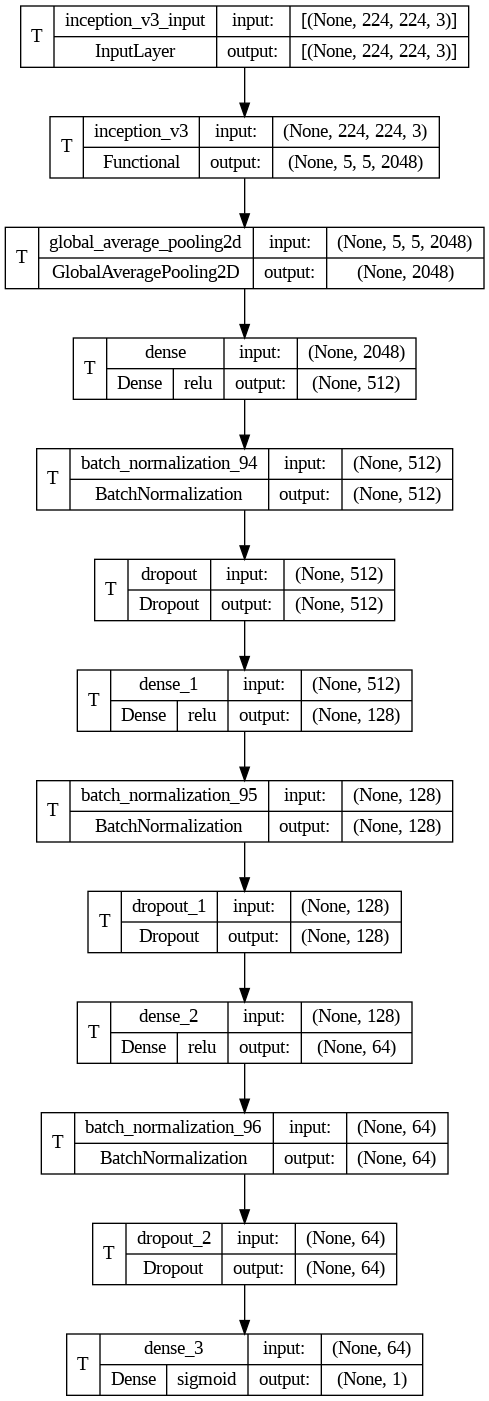

In [ ]:
visualkeras.layered_view(model_icp, to_file="/content/drive/MyDrive/XRAY/assets/layered_model_icp.png").show() # display using your system viewer
# print(model_xcp.summary())
tf.keras.utils.plot_model(
    model_icp,
    to_file='/content/drive/MyDrive/XRAY/assets/model_icp.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_icp = model_icp.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train) // BATCH,
    validation_steps=len(validation),
    validation_freq=1
)

Epoch 1/20
20/20 [==============================] - 53s 883ms/step - loss: 0.9858 - accuracy: 0.0000e+00 - precision: 0.7011 - recall: 0.5701 - val_loss: 1.5013 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 17s 835ms/step - loss: 0.7589 - accuracy: 0.0000e+00 - precision: 0.9487 - recall: 0.5781 - val_loss: 4.5095 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.0000e+00 - precision: 0.9070 - recall: 0.6555
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 20s 970ms/step - loss: 0.6206 - accuracy: 0.0000e+00 - precision: 0.9070 - recall: 0.6555 - val_loss: 25.3092 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/20
20/20 [===================

#### Plot Training Progress

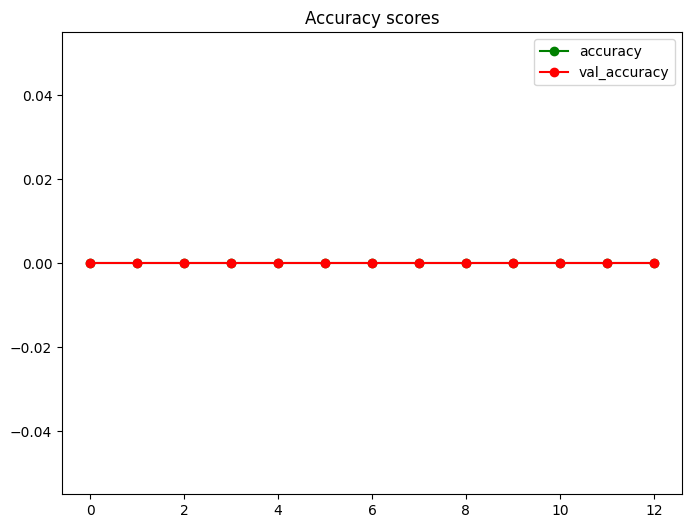

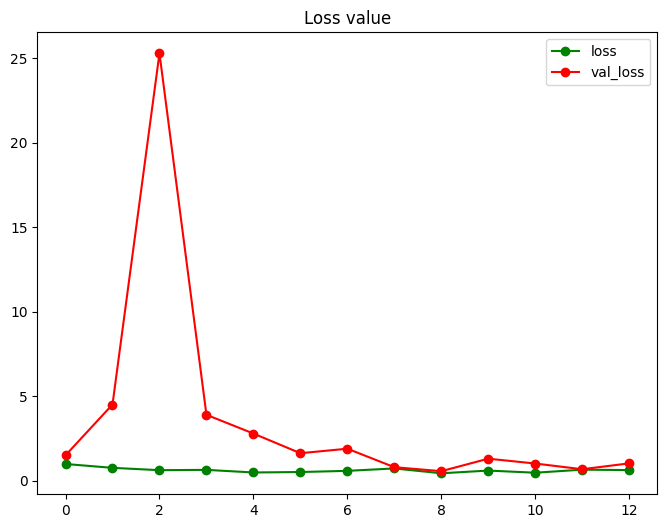

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_icp.history['accuracy'],'go-')
plt.plot(trainer_icp.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/inet_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_icp.history['loss'],'go-')
plt.plot(trainer_icp.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/inet_loss.png")

plt.show()

#### Model Evaluation

In [ ]:
pred = model_icp.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True)))
# Save the model
model_icp.save("/content/drive/MyDrive/XRAY/assets/best_model_inception.hdf5")

624/624 [==============================] - 126s 201ms/step
[[183  51]
 [ 63 327]]


0           1  accuracy   macro avg  weighted avg
precision    0.743902    0.865079  0.817308    0.804491      0.819638
recall       0.782051    0.838462  0.817308    0.810256      0.817308
f1-score     0.762500    0.851562  0.817308    0.807031      0.818164
support    234.000000  390.000000  0.817308  624.000000    624.000000

### Transfer Learning: ResNet

In [ ]:
from keras.applications import ResNet50

keras.backend.clear_session()
resnet_base_model = ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')

model_rnet = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])


opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_rnet.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)

94765736/94765736 [==============================] - 1s 0us/step


#### Visualize ResNet Model

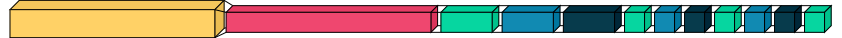

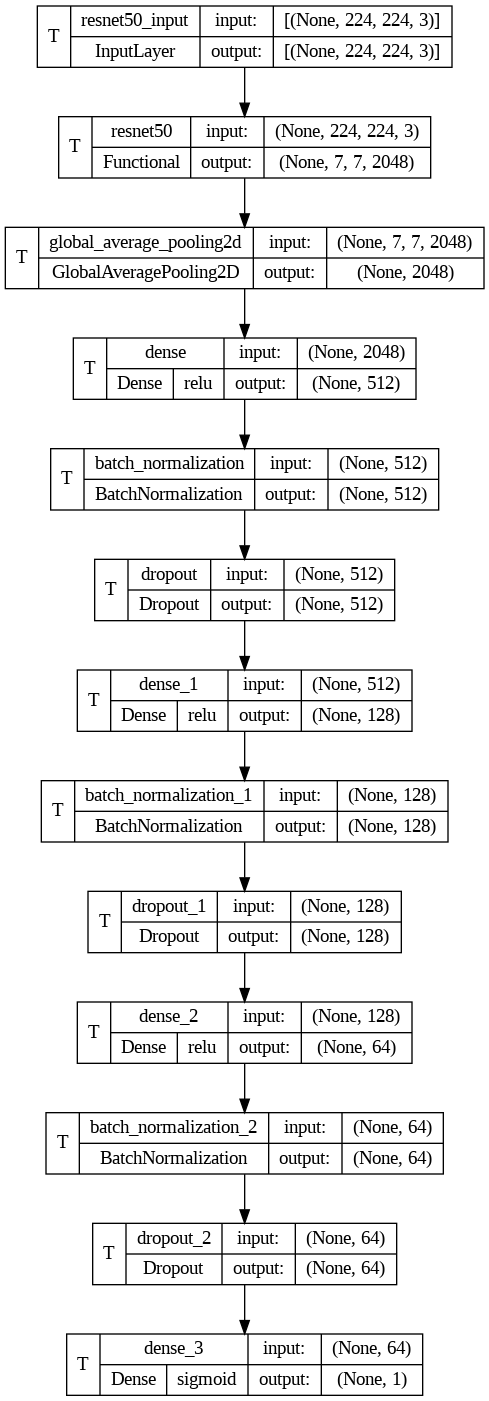

In [ ]:
visualkeras.layered_view(model_rnet, to_file="/content/drive/MyDrive/XRAY/assets/layered_model_rnet.png").show() # display using your system viewer
# print(model_xcp.summary())
tf.keras.utils.plot_model(
    model_rnet,
    to_file='/content/drive/MyDrive/XRAY/assets/model_resnet.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_rnet = model_rnet.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train) // BATCH,
    validation_steps=len(validation),
    validation_freq=1
)

Epoch 1/20
20/20 [==============================] - 50s 766ms/step - loss: 0.7633 - accuracy: 0.0000e+00 - precision: 0.8941 - recall: 0.6129 - val_loss: 73.2026 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 24s 1s/step - loss: 0.7717 - accuracy: 0.0000e+00 - precision: 0.9036 - recall: 0.6048 - val_loss: 38874.0898 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.0000e+00 - precision: 0.9020 - recall: 0.7931
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 14s 667ms/step - loss: 0.6033 - accuracy: 0.0000e+00 - precision: 0.9020 - recall: 0.7931 - val_loss: 71339.9922 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/20
20/20 [==========================

#### Plot Training Progress

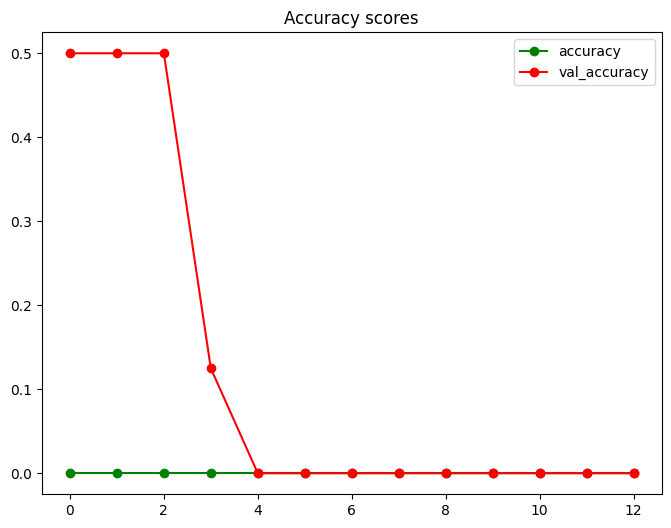

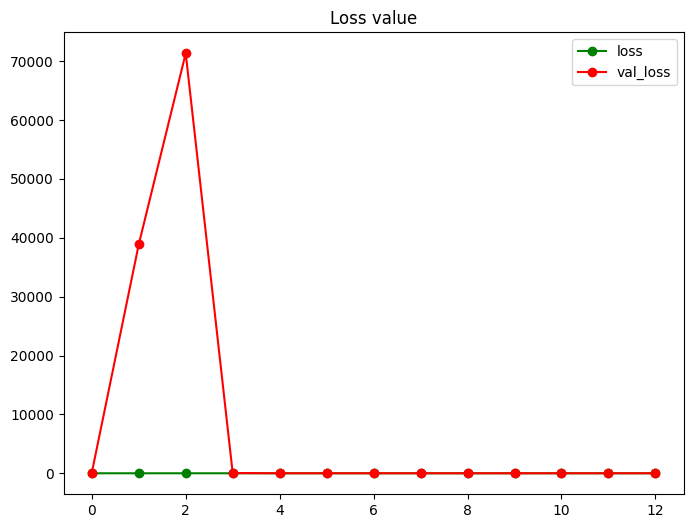

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_rnet.history['accuracy'],'go-')
plt.plot(trainer_rnet.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/rnet_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_rnet.history['loss'],'go-')
plt.plot(trainer_rnet.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/rnet_loss.png")

plt.show()

#### Model Evaluation

In [ ]:
pred = model_rnet.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5 , output_dict=True)))
# Save the model
model_rnet.save("/content/drive/MyDrive/XRAY/assets/best_model_resnet.hdf5")

624/624 [==============================] - 81s 130ms/step
[[  0 234]
 [  0 390]]


0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000

### Transfer Learning: ViT

In [ ]:
keras.backend.clear_session()

model_vit = vit.vit_b16(
    image_size = IMG_SIZE,
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 1
)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    tf.keras.losses.BinaryCrossentropy(name="loss"),
    tf.keras.metrics.Accuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_vit.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              run_eagerly=True,
              metrics=METRICS)


347502902/347502902 [==============================] - 3s 0us/step


#### Visualize ViT Model

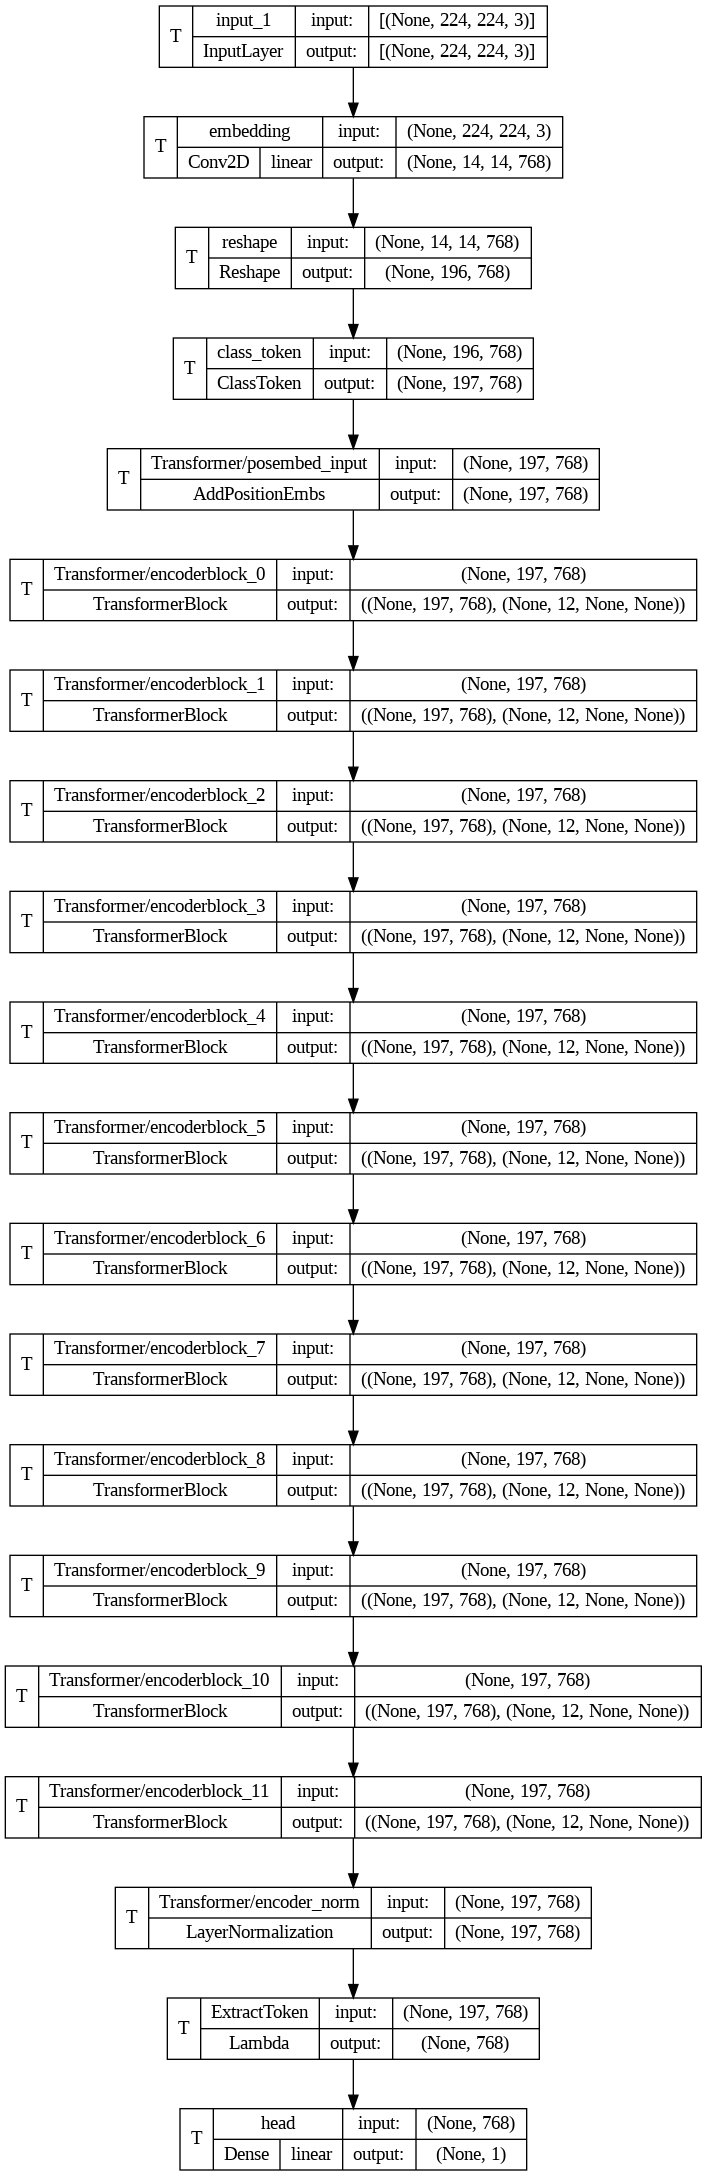

In [ ]:
# print(model_xcp.summary())
tf.keras.utils.plot_model(
    model_vit,
    to_file='/content/drive/MyDrive/XRAY/assets/model_vit.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

#### Start Training

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = 1,
    mode = "max",
)
PT = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000000001,
    cooldown = 1
)

trainer_vit = model_vit.fit(
    train,
    epochs = EPOCH,
    batch_size = BATCH,
    validation_data = validation,
    callbacks = [PT, ES],
    class_weight = class_weight,
    steps_per_epoch=len(train) // BATCH,
    validation_steps=len(validation),
    validation_freq=1
)

Epoch 1/20
20/20 [==============================] - 53s 1s/step - loss: 11.0110 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.0336 - val_loss: 7.7125 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 24s 1s/step - loss: 11.9543 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 7.7125 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 10.6047 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
20/20 [==============================] - 23s 1s/step - loss: 10.6047 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 7.7125 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/20
20/20 [=

#### Plot Training Progress

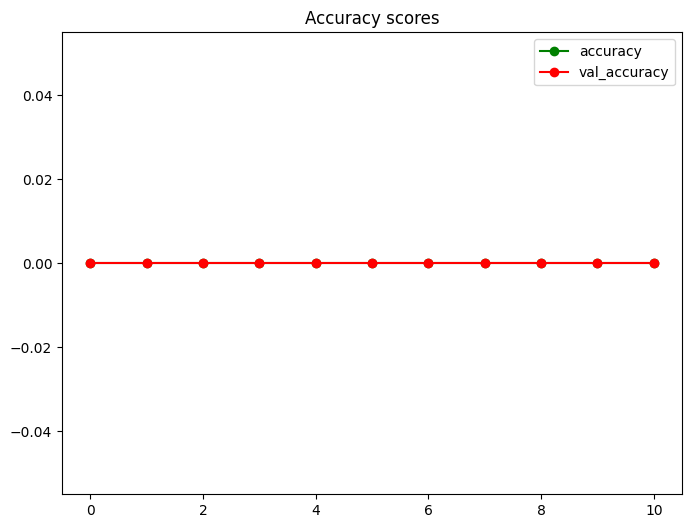

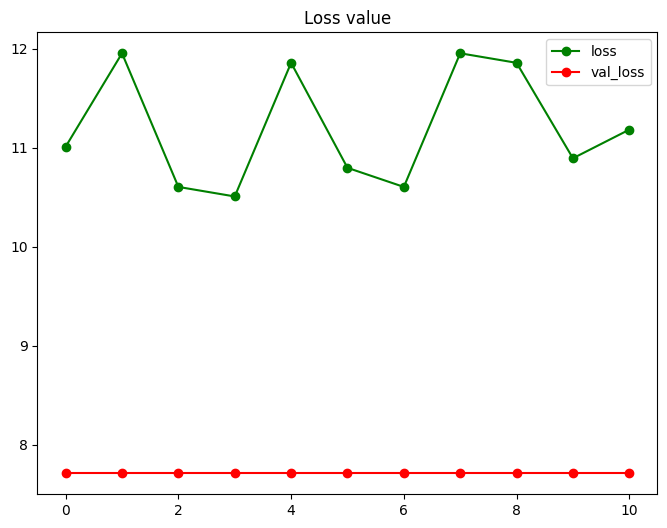

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(trainer_vit.history['accuracy'],'go-')
plt.plot(trainer_vit.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/vit_accuracy.png")

plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(trainer_vit.history['loss'],'go-')
plt.plot(trainer_vit.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.savefig("/content/drive/MyDrive/XRAY/assets/vit_loss.png")

plt.show()

#### Model Evaluation

In [ ]:
pred = model_vit.predict(test)
print(confusion_matrix(test.classes, pred > 0.5))
display(pd.DataFrame(classification_report(test.classes, pred > 0.5 , output_dict=True)))
# Save the model
model_vit.save("/content/drive/MyDrive/XRAY/assets/best_model_vit.hdf5")

624/624 [==============================] - 154s 247ms/step
[[234   0]
 [390   0]]


0      1  accuracy   macro avg  weighted avg
precision    0.375000    0.0     0.375    0.187500      0.140625
recall       1.000000    0.0     0.375    0.500000      0.375000
f1-score     0.545455    0.0     0.375    0.272727      0.204545
support    234.000000  390.0     0.375  624.000000    624.000000